In [1]:
%matplotlib notebook
from brian2 import *
from matplotlib.pyplot import *
import numpy as np
import random as rp
import time
import copy
from data_generator import *
from numpy import loadtxt

import cv2
from matplotlib import pyplot as plt
print(cv2.__version__);
print(np.__version__);

# packages needed for image difference
from skimage.measure import compare_ssim
import argparse
import imutils

4.1.0
1.17.4


In [2]:
# Load network
data_path = './data150/'
StE_w = loadtxt(data_path+'StEw.csv', delimiter=',') 
StE_delay = loadtxt(data_path+'StEdelay.csv', delimiter=',')
EtI_w = loadtxt(data_path+'EtIw.csv', delimiter=',')
mapped = loadtxt(data_path+'Map.csv', delimiter=',')

# Label neurons as 1/3 left and 1/3 right
left_neurons = []
right_neurons = []
for j in range(len(mapped)):
    if mapped[j] < int(len(mapped)/3):
        left_neurons.append(j)
    elif mapped[j] > int(len(mapped)/1.5):
        right_neurons.append(j)
        
start_scope()
#defaultclock.dt = 3*ms
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
th : 1
'''

taupre = taupost = 100*ms
wmax = 2
wmin = 0.001
Apre = 0.0005
Apost = -Apre*taupre/taupost*1.05

inner_size = len(EtI_w)
S=NeuronGroup(256, eqs, threshold='v>1', reset='v = 0', method='exact')
E = NeuronGroup(inner_size, eqs, threshold='v>1.5', reset='v = 0', method='exact')
I = NeuronGroup(inner_size, eqs, threshold='v>0.5', reset='v = 0', method='exact')


StE= Synapses(S, E,'''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, wmin, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, wmin, wmax)
             ''')
StE.connect(p=1)

EtI= Synapses(E, I,'''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, wmin, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, wmin, wmax)
             ''')
EtI.connect(condition='i==j')


ItE= Synapses(I, E,  'w : 1', on_pre='v_post = 0')
ItE.connect(condition='i!=j')

taupre = taupost = 100*ms
wmax = 2
wmin = 0.001
Apre = 0.002
Apost = -Apre*taupre/taupost*1.5

S.tau=60*ms
S.I=0
E.tau=100*ms
E.I=0

I.tau=50*ms

StE.w = StE_w
for j in range(len(StE_delay)): 
    StE.delay[j] = StE_delay[j]*second
EtI.w = EtI_w

# Add the output layer
OUT = NeuronGroup(2, eqs, threshold='v>th', reset='v = 0', method='exact')
OUT.tau=100*ms
OUT.th[0]=1 #0.6
OUT.th[1]=1 #0.6

EtOUT= Synapses(E, OUT, 'w : 1', on_pre='v_post += w')

# Connect left_neurons to one output and right_neurons to the other
EtOUT.connect(i=left_neurons, j=0)
EtOUT.connect(i=right_neurons, j=1)
EtOUT.w = 1

M = StateMonitor(S, 'v', record=True)
spikemonE = SpikeMonitor(E)
spikemonI = SpikeMonitor(I)
spikemonS = SpikeMonitor(S)
spikemonOUT = SpikeMonitor(OUT)

net = Network(S, E, I, StE, EtI, ItE, OUT, EtOUT, spikemonE, spikemonI, spikemonS, spikemonOUT)
Apre = 0
Apost = 0

ItE.w = 0


print("done")

done


Epoch 0


<IPython.core.display.Javascript object>


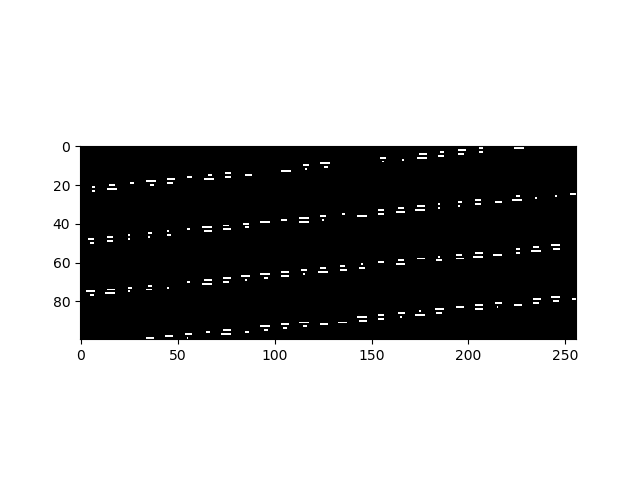

Epoch 1
155.56997179985046 s


<IPython.core.display.Javascript object>


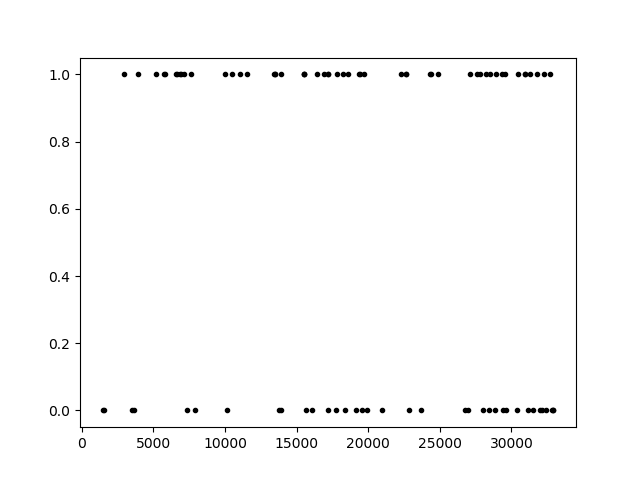

36 53


In [7]:
def run_data(data, time_step=33*ms):
    imgplot = plt.imshow(data)
    plt.show()
    
    for j in range(len(data)):
        S.I=[f[0]*3 for f in data[j]]
        net.run(time_step)
        
def test(samples_per_epoch):
    left = 1
    right = 0
    
    start = time.time()
    for e in range(2):
        print("Epoch", e)
        #data, answers = data_generator(samples_per_epoch, pixels=256, speed_range=(10,11), objects=1, label_delay=0, 
        #                       noise=0.00, left=left, right=right, loop_around=True)
        data, answers = data_generator(samples_per_epoch, pixels=256, rand_width=3, speed_range=(10,11), width=0, objects=1, label_delay=0, 
                               noise=0.0, left=1, right=0, loop_around=True)
        #data, answers = data_generator(samples_per_epoch, pixels=256, objects=1, label_delay=0, 
        #                               noise=0.00, left=left, right=right, loop_around=True)
        run_data(data)
        
        left = not left
        right = not right
    print(time.time() - start,"s")

    figure(20)
    plot(spikemonOUT.t/ms, spikemonOUT.i, '.k')
    
def run_network(data):
    print("Starting analysis")
    Apre = 0
    Apost = 0
    start = time.time()
    run_data(data)
    print(time.time() - start,"s")

    figure(40)
    plot(spikemonOUT.t/ms, spikemonOUT.i, '.k')

test_len = 200
test(int(test_len/2))

# Count number of spikes
l_spike = 0
r_spike = 0
for spike in spikemonOUT.i:
    if spike == 0:
        l_spike += 1
    else:
        r_spike += 1
print(l_spike, r_spike)

9 8


<IPython.core.display.Javascript object>


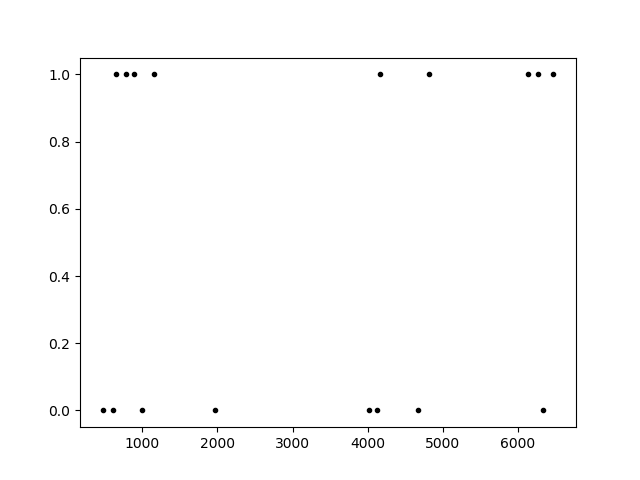

Accuracy is:  0.365
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
-1


In [11]:
# If more spikes occured in the same direction in the last sample_time ms 
# label the frame as that direction
def label_frames(num_frames, frame_time, spikemonOUT, sample_time, decay, left_weight, right_weight):
    label = np.zeros(num_frames)
    t = 0
    
    for j in range(num_frames):
        t += frame_time
        
        replay = spikemonOUT.t[0]/ms
        k = 0
        left = 0
        right = 0
        while replay < t:
            if replay > t - sample_time:
                left *= decay # Decay old values
                right *= decay 
                if spikemonOUT.i[k] == 1:
                    left += left_weight
                else:
                    right += right_weight
            k += 1
            if k >= len(spikemonOUT.i):
                break
            replay = spikemonOUT.t[k]/ms
        
        if left > right:
            label[j] = -1
        elif left < right:
            label[j] = 1
        
    return label

# Looks at all spikes picks the direction with most spikes
def label_run():
    left = 0
    right = 0

    for j in range(len(spikemonOUT.i)):
        if spikemonOUT.i[j] == 1:
            left += 1
        else:
            right += 1
    print(left, right)
    if left > right:
        return -1
    return 1

run_dir = label_run()
labels = label_frames(test_len, 33, spikemonOUT, 33*30-1, 0.995, l_spike/r_spike, 1)
figure(42398)
plot(spikemonOUT.t/ms, spikemonOUT.i, '.k')

def accuracy ():
    correct = 0
    for j in range(len(labels)):
        if j < len(labels)/2:
            if labels[j] == -1:
                correct += 1
        elif labels[j] == 1:
            correct += 1

    return correct / len(labels)

acc = accuracy()

print("Accuracy is: ", acc)
print(labels)
print(run_dir)

In [5]:
l_spike = 0
r_spike = 0
for spike in spikemonOUT.i[:int(len(spikemonOUT)/2):]:
    if spike == 0:
        l_spike += 1
    else:
        r_spike += 1
print(l_spike, r_spike)
                           
l_spike = 0
r_spike = 0
for spike in spikemonOUT.i[int(len(spikemonOUT)/2):]:
    if spike == 0:
        l_spike += 1
    else:
        r_spike += 1
print(l_spike, r_spike)

2 3
5 1


In [6]:
def cameraloop(cap):
        
    #every session has a new batch of images
    image_number = 0;

    first_flag = 0;
    second_flag = 0;

    recorded = np.zeros((1,256))
    print(recorded.shape)

    
    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        if first_flag == 1:#print(self.vid.width)
            last_gray = copy.copy(gray)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            dst1 = gray
            dst2 = last_gray

            if (second_flag == 1):
                last_thresh = thresh

            (score, diff) = compare_ssim(dst1, dst2, full=True)
            diff = (diff * 255).astype("uint8")
            sens = 40
            diff[diff > sens] = 255
            diff[diff <= sens] = 0

            x = diff.shape[0]
            y = diff.shape[1]

            a = int(round(x/2 - 1, 0))
            b = int(round(x/2,0))
            c = int(round(y/2))
            d = int(round(256/2))

            thresh = cv2.bitwise_not(diff)

            if second_flag == 1:
                backtorgb = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)
                backtorgb[np.where((backtorgb==[255,255,255]).all(axis=2))] = [0,255,0]
                backtorgb2 = cv2.cvtColor(last_thresh,cv2.COLOR_GRAY2RGB)
                backtorgb[np.where((backtorgb2==[255,255,255]).all(axis=2))] = [0,0,255]

                red_green = backtorgb + backtorgb2



            diff_row = thresh[a:b, c-d:c+d]
            recorded = np.vstack((recorded, diff_row))


        if first_flag == 1:
            cv2.imshow('thresh', thresh)
        else:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if (second_flag == 1):
            cv2.imshow('row', diff_row)
            cv2.imshow('recorded', recorded)

        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
        if cv2.waitKey(20) & 0xFF == ord('r'):
            # Input data to network
            run_network(recorded)
            recorded = np.zeros((1,256))
            
        if (first_flag == 1):
            second_flag = 1;

        first_flag = 1


In [4]:
cap = cv2.VideoCapture(0)

cameraloop(cap)

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

(1, 256)


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/highgui/src/window.cpp:698: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'
